# A Chemistry-Based Approach to Estimating NBA Team Power: An N-Max Framework

## By Dylan Hong for Math 76 with Professor Timmy Ma

In [135]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguedashlineups
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashlineups
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import leaguestandings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import time

In [136]:
#Gets Lineup Data from API for a given season
def LineupData(season,per):
    tempdf = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf1 = tempdf[['GROUP_ID','GP','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [137]:
#Gets Player Data from API for a given season
def PlayerData(season,per):
    tempdf1 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Advanced', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Usage', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Misc', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Scoring', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Defense', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf = pd.merge(tempdf1,tempdf2, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    print('done')
    return(tempdf)

In [138]:
#Returns dictionary of N-scores for given players in given set of attributes
def nMax(n,playerids,attributes,df):
    teamscore = 0
    #Loop through players in lineup
    teamAttr = defaultdict(list)
    for player in playerids:
        try:
            playerstats = df.loc[df['PLAYER_ID'] == int(player)]
            
            for attr in attributes:
                playerscore = playerstats.iloc[0][attr]
                teamAttr[attr].append(playerscore)

        except:
            continue            
            
    rawAttr = defaultdict()
    for x in teamAttr:
        teamAttr[x].sort(reverse = True)
        teamAttr[x] = teamAttr[x][:n]
        rawAttr[x] = sum(teamAttr[x][:n])
    return(rawAttr)

In [139]:
#Gets the most played lineups for each team during the given season
def GetLineups(season):
    nba_teams = teams.get_teams()

    teamLineups = defaultdict(str)
    for team in nba_teams:
        teamid = team['id']
        teamdf = teamdashlineups.TeamDashLineups(team_id = teamid, season = season, per_mode_detailed = 'Totals').get_data_frames()[1]
        #print(teamdf.head())
        teamdf.sort_values('MIN',ascending = False)
        teamLineups[team['abbreviation']] = teamdf.iat[0,1].split("-")[1:-1]
        #print("done")
        #print(teamLineups)
        time.sleep(1)
    
    print("done")
    return(teamLineups)

In [140]:
#Adds in player height and experience
def getPlayerInfo(df):
    nba_teams = teams.get_teams()
    tempdf = pd.DataFrame()

    for team in nba_teams:
        teamid = team['id']
        roster = commonteamroster.CommonTeamRoster(team_id = teamid,season = '2017-18').get_data_frames()[0]
        tempdf = tempdf.append(roster)

        time.sleep(1)

    newRoster = tempdf[['PLAYER_ID','HEIGHT','EXP']].copy()
    df = df.merge(newRoster,on='PLAYER_ID',how='left')
    
    for index, row in df.iterrows():
        if pd.isnull(row['HEIGHT']):
            df.at[index,'HEIGHT'] = 0   
        else:
            feet = row['HEIGHT'].split('-')[0]
            #print(feet)
            inches = row['HEIGHT'].split('-')[1]
            df.at[index,'HEIGHT'] = 12*int(feet) + int(inches)    
        exp = row['EXP']
        if exp == 'R' or pd.isnull(exp):
            df.at[index,'EXP'] = 0
        else:
            df.at[index,'EXP'] = int(exp)
    
    
    print("done")
    return(df)

In [141]:
#Get the log of games for a given season
def getGameLog(season):
    games = leaguegamelog.LeagueGameLog(season_all_time = season).get_data_frames()[0]
    games.drop_duplicates('GAME_ID',inplace = True)
    dummy = pd.get_dummies(games['WL'])
    games = pd.concat([games,dummy],axis = 1)
    
    return(games)

In [142]:
dfLineup = LineupData('2017-18','Per100Possessions')
dfPlayer = PlayerData('2017-18','Per100Possessions')
dfPlayer = getPlayerInfo(dfPlayer)
teamLineups = GetLineups('2017-18')
print(len(dfLineup))
print(len(dfPlayer))
print(len(teamLineups))
#print(list(dfPlayer.columns))
dfPlayer.head()

done
done
done
done
2000
540
30


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DEF_WS,HEIGHT,EXP
0,201166,Aaron Brooks,1610612750,MIN,33.0,32,19,13,0.594,47.1,...,0.240,0.118,0.882,0.818,0.182,0.393,0.607,0.014,72,9
1,203932,Aaron Gordon,1610612753,ORL,22.0,58,19,39,0.328,47.6,...,0.407,0.488,0.512,0.835,0.165,0.595,0.405,0.129,81,3
2,1626151,Aaron Harrison,1610612742,DAL,23.0,9,2,7,0.222,48.6,...,0.233,0.300,0.700,1.000,0.000,0.632,0.368,0.066,78,2
3,1628935,Aaron Jackson,1610612745,HOU,32.0,1,0,1,0.000,51.5,...,0.500,0.500,0.500,0.000,1.000,0.333,0.667,0.146,75,0
4,1627846,Abdel Nader,1610612738,BOS,24.0,48,33,15,0.688,47.2,...,0.342,0.333,0.667,0.957,0.043,0.620,0.380,0.150,78,0


In [143]:
#Set attributes
attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']

#rand = nMax(2,['2585', '201142', '201939', '202691', '203110'],attributes)
#print(rand)

In [144]:
#Build the team score based on the model
masterVals = defaultdict(list)
N = 3
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes,dfPlayer)
    
    #Get averages to normalize
    for key1, value1 in vals.items():
        masterVals[key1].append(value1)

#Get normalized coefficients
normalCoeffs = defaultdict(float)
L = 100
for x in masterVals:
        normalCoeffs[x] = (L/np.mean(masterVals[x]))

#Work with coefficients
#Offensive
normalCoeffs['AST'] = normalCoeffs['AST'] * 2
normalCoeffs['OREB'] = normalCoeffs['OREB'] * 2
normalCoeffs['FG_PCT'] = normalCoeffs['FG_PCT'] * 1
normalCoeffs['FG3_PCT'] = normalCoeffs['FG3_PCT'] * 1
normalCoeffs['TOV'] = normalCoeffs['TOV'] * -2
normalCoeffs['OFF_RATING'] = normalCoeffs['OFF_RATING'] * 2
normalCoeffs['PTS'] = normalCoeffs['PTS'] * 1

#Defensive
normalCoeffs['DREB'] = normalCoeffs['DREB'] * 1
normalCoeffs['STL'] = normalCoeffs['STL'] * 2
normalCoeffs['DEF_RATING'] = normalCoeffs['DEF_RATING'] * - 1
normalCoeffs['PF'] = normalCoeffs['PF'] * -2

#Attributes
normalCoeffs['HEIGHT'] = normalCoeffs['HEIGHT'] * 1
normalCoeffs['EXP'] = normalCoeffs['EXP'] * 2

#print(normalCoeffs)

#Calculate score for each team
teamRank = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes,dfPlayer)
    
    score = 0
    test = {}
    for key1,value1 in vals.items():
        score = score + (normalCoeffs[key1]*value1)
        test[key1] = normalCoeffs[key1]*value1
        
    teamRank[key] = score
    
print(teamRank)
#print(test)

defaultdict(<class 'int'>, {'ATL': 1000.5317450595924, 'BOS': 1057.7661157038217, 'CLE': 1145.6398251146995, 'NOP': 1246.371258944976, 'CHI': 938.6281972023788, 'DAL': 1024.9556963329665, 'DEN': 1119.5910368078028, 'GSW': 1260.0342281493845, 'HOU': 1338.8643257872434, 'LAC': 1100.0397606861836, 'LAL': 924.1498886563492, 'MIA': 1171.610662958657, 'MIL': 1084.3805547412883, 'MIN': 1184.977903448418, 'BKN': 1002.4593740072623, 'NYK': 1152.203991746499, 'ORL': 967.9408960942432, 'IND': 1168.4880750842062, 'PHI': 1060.745954584338, 'PHX': 1003.0279245699747, 'POR': 1001.0096025307257, 'SAC': 905.9193557672493, 'SAS': 1274.1536375050766, 'OKC': 1313.8308039346089, 'TOR': 1134.49031099941, 'UTA': 1159.6353928212322, 'MEM': 968.8283429211115, 'WAS': 1054.0678873384563, 'DET': 1050.9166804960223, 'CHA': 1184.740570005825})


## Results for a Single Game

In [145]:
#First get log of all the games for the season
games = getGameLog('2017-18')
print("There are " + str(len(games)) + " in the season.")

#Add in Scores to games
for index, row in games.iterrows():
    home = row['MATCHUP'].split(' ')[0]
    away = row['MATCHUP'].split(' ')[2]
    games.at[index,'homeScore'] = teamRank[home]
    games.at[index,'awayScore'] = teamRank[away]
    games.at[index,'netScore'] = teamRank[home] - teamRank[away]
    
games.head()

There are 1230 in the season.


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,L,W,homeScore,awayScore,netScore
0,22017,1610612744,GSW,Golden State Warriors,0021700002,2017-10-17,GSW vs. HOU,L,240,43,...,17,25,121,-1,1,1,0,1260.034228,1338.864326,-78.830098
2,22017,1610612738,BOS,Boston Celtics,0021700001,2017-10-17,BOS @ CLE,L,240,36,...,12,24,99,-3,1,1,0,1057.766116,1145.639825,-87.873709
4,22017,1610612750,MIN,Minnesota Timberwolves,0021700011,2017-10-18,MIN @ SAS,L,240,37,...,13,16,99,-8,1,1,0,1184.977903,1274.153638,-89.175734
6,22017,1610612757,POR,Portland Trail Blazers,0021700012,2017-10-18,POR @ PHX,W,240,44,...,18,20,124,48,1,0,1,1001.009603,1003.027925,-2.018322
8,22017,1610612738,BOS,Boston Celtics,0021700007,2017-10-18,BOS vs. MIL,L,240,39,...,15,27,100,-8,1,1,0,1057.766116,1084.380555,-26.614439


In [146]:
#Run Regressions on results
exog = sm.add_constant(games['netScore'])

model1 = sm.OLS(games['PLUS_MINUS'],games['netScore']).fit()
model2 = sm.OLS(games['PLUS_MINUS'],exog).fit()
model3 = sm.OLS(games['W'],games['netScore']).fit()
model4 = sm.OLS(games['W'],exog).fit()
model5 = sm.Logit(games['W'],games['netScore']).fit()
model4.summary()

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 43.908455
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     106.1
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           6.26e-24
Time:                        16:06:53   Log-Likelihood:                -841.58
No. Observations:                1230   AIC:                             1687.
Df Residuals:                    1228   BIC:                             1697.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4924      0.014     35.973      0.000       0.466       0.519
netScore       0.0009   8.28e-05     10.303      0.000       0.001       0.001
==============================================================================
Omnibus:                     5960.197   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.944
Skew:                           0.022   Prob(JB):                     3.36e-32
Kurtosis:                       1.319   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Plus - Minus')

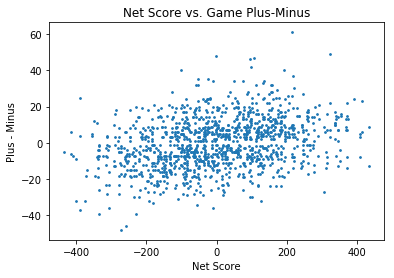

In [147]:
#Plot the results
plt.figure(1)
plt.scatter(games['netScore'],games['PLUS_MINUS'],s = 3)
#plt.scatter(games['netScore'],games['W'],s = 3)
plt.title("Net Score vs. Game Plus-Minus")
plt.xlabel("Net Score")
plt.ylabel("Plus - Minus")

In [148]:
#Examine the proportion of correctly predicted games in a sesaon
total = 0
correct = 0 
for index, row in games.iterrows():
    if row['W'] == 1 and row['netScore'] > 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 0 and row['netScore'] < 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 1 and row['netScore'] < 0:
        total = total + 1
    elif row['W'] == 0 and row['netScore'] > 0:
        total = total + 1
print(correct)
print(total)
print(correct/total)

757
1230
0.6154471544715447


## Results for a Season

In [149]:
#Get standings for the season
stand = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
nba_teams = teams.get_teams()

for index, row in stand.iterrows():
    preaswin = row['PreAS'].split('-')[0]
    stand.at[index,'PreASWins'] = int(preaswin)0
    postaswin = row['PostAS'].split('-')[0]
    stand.at[index,'PostASWins'] = int(postaswin)

lookup = {}
for team in nba_teams:
    teamid = team['id']
    lookup[team['nickname']] = team['abbreviation']

for index, row in stand.iterrows():
    name = row['TeamName']
    if name == 'Bobcats':
        abbrev = 'CHA'
    if name == 'SuperSonics':
        abbrev = 'OKC'
    else:
        abbrev = lookup[name]
    stand.at[index,'score'] = teamRank[abbrev]

#print(stand['WINS'])
stand.head()

SyntaxError: invalid syntax (<ipython-input-149-bfd9a821cbd4>, line 7)

In [ ]:
#Run Regressions on Results
model = sm.OLS(stand['WINS'],stand['score']).fit()
model.summary()

In [ ]:
#Plot the results
plt.figure(1)
plt.scatter(stand['score'],stand['WINS'],s = 30)
plt.title("Score vs. Wins Per Season")
plt.xlabel("Score")
plt.ylabel("Wins")

## Predicting End of Season Standings

In [ ]:
#Train the Model on last years statistics
dfLineupPred = LineupData('2016-17','Per100Possessions')
dfPlayerPred = PlayerData('2016-17','Per100Possessions')
dfPlayerPred = getPlayerInfo(dfPlayerPred)
teamLineupsPred = GetLineups('2017-18')
results = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
print(len(dfLineup))
print(len(dfPlayer))
print(len(teamLineups))
#print(list(dfPlayer.columns))
dfPlayer.head()

In [ ]:
attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']

masterVals = defaultdict(list)
N = 3
for key, value in teamLineupsPred.items():
    vals = nMax(N,value,attributes,dfPlayerPred) #Not all players have stats - rookies #put in rookie as all 0s
    
    #Get averages to normalize
    for key1, value1 in vals.items():
        masterVals[key1].append(value1)

#Get normalized coefficients
normalCoeffs = defaultdict(float)
L = 100
for x in masterVals:
        normalCoeffs[x] = (L/np.mean(masterVals[x]))

#Work with coefficients
#Offensive
normalCoeffs['AST'] = normalCoeffs['AST'] * 2
normalCoeffs['OREB'] = normalCoeffs['OREB'] * 2
normalCoeffs['FG_PCT'] = normalCoeffs['FG_PCT'] * 1
normalCoeffs['FG3_PCT'] = normalCoeffs['FG3_PCT'] * 1
normalCoeffs['TOV'] = normalCoeffs['TOV'] * -2
normalCoeffs['OFF_RATING'] = normalCoeffs['OFF_RATING'] * 2
normalCoeffs['PTS'] = normalCoeffs['PTS'] * 1

#Defensive
normalCoeffs['DREB'] = normalCoeffs['DREB'] * 1
normalCoeffs['STL'] = normalCoeffs['STL'] * 2
normalCoeffs['DEF_RATING'] = normalCoeffs['DEF_RATING'] * -1
normalCoeffs['PF'] = normalCoeffs['PF'] * -2

#Attributes
normalCoeffs['HEIGHT'] = normalCoeffs['HEIGHT'] * 1
normalCoeffs['EXP'] = normalCoeffs['EXP'] * 2

#print(normalCoeffs)

#Calculate score for each team
teamRankPred = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes,dfPlayerPred)
    
    score = 0
    test = {}
    for key1,value1 in vals.items():
        score = score + (normalCoeffs[key1]*value1)
        test[key1] = normalCoeffs[key1]*value1
        
    teamRankPred[key] = score
    
print(teamRankPred)
#print(test)

In [ ]:
#Use the model to predict the number of wins for each team
predStanding = defaultdict(int)
for key,value in teamRankPred.items():
    wins = model.predict(value)
    wins = round(wins[0])
    predStanding[key] = wins

predStanding

## ALL-STAR BREAK PREDICTIONS

In [ ]:
#Updated to get data from pre all star
def PlayerDataAll(season,per):
    tempdf1 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Base', 
                                                 season = season, season_segment_nullable = 'Pre All-Star',
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Advanced', 
                                                 season = season, season_segment_nullable = 'Pre All-Star',
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Usage', 
                                                 season = season, season_segment_nullable = 'Pre All-Star',
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Misc', 
                                                 season = season, season_segment_nullable = 'Pre All-Star',
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Scoring', 
                                                 season = season, season_segment_nullable = 'Pre All-Star',
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Defense', 
                                                 season = season, season_segment_nullable = 'Pre All-Star',
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf = pd.merge(tempdf1,tempdf2, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    print('done')
    return(tempdf)

In [ ]:
#Train the Model on last years statistics
dfLineupAll = LineupData('2017-18','Per100Possessions')
dfPlayerAll = PlayerDataAll('2017-18','Per100Possessions')
dfPlayerAll = getPlayerInfo(dfPlayerAll)
teamLineupsAll = GetLineups('2017-18')
resultsAll = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
print(len(dfLineup))
print(len(dfPlayer))
print(len(teamLineups))
#print(list(dfPlayer.columns))
dfPlayer.head()

In [ ]:
#AllStar = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
for index, row in resultsAll.iterrows():
    preaswin = row['PreAS'].split('-')[0]
    stand.at[index,'PreASWins'] = int(preaswin)
    postaswin = row['PostAS'].split('-')[0]
    stand.at[index,'PostASWins'] = int(postaswin)

exog = stand[['score','PreASWins']].copy()
model2 = sm.OLS(stand['PostASWins'],exog).fit()
model3 = sm.OLS(stand['PostASWins'],stand['score']).fit()
model2.summary()

In [ ]:
#Plot the results
plt.figure(1)
plt.scatter(stand['score'],stand['PostASWins'],s = 30)
plt.title("Pre All Star Score vs. Post All Star Wins")
plt.xlabel("Pre All Star Score")
plt.ylabel("Post All Star Wins")

plt.figure(2)
plt.scatter(stand['PreASWins'],stand['PostASWins'],s = 30)
plt.title("Pre All Star Wins vs. Post All Star Wins")
plt.xlabel("Pre All Star Wins")
plt.ylabel("Post All Star Wins")